# Fig. 1, Extended Fig. 1: Licking and speed behavior

Requires a pre-saved `sess` class for each animal and day (each session)

In [1]:
import math
import dill
import numpy as np
import copy
from tqdm import tqdm
import warnings

import os
from matplotlib import pyplot as plt
from matplotlib import cm

import reward_relative.behavior as behav
from reward_relative import utilities as ut
from reward_relative import plotUtils as pt
from reward_relative import dayData as dd
    
import TwoPUtils

%matplotlib inline

%load_ext autoreload
%autoreload 2

## SET FIGURE PARAMETERS
pt.set_fig_params(fontsize=12)

#### Specify your path dictionary

Copy and rename `path_dict.py` to a new file and edit it with the paths on your system.  \
Current options:
`path_dict_josquin`, `path_dict_firebird`, etc



In [3]:
from reward_relative.path_dict_firebird import path_dictionary as path_dict
path_dict

{'preprocessed_root': '/data/2P',
 'sbx_root': '/mnt/oak/InVivoDA/2P_Data',
 'gdrive_root': '/mnt/gdrive/2P_Data',
 'VR_Data': '/data/2P/VR_Data',
 'git_repo_root': '/home/mari/local_repos/2p_repos',
 'TwoPUtils': '/home/mari/local_repos/2p_repos/TwoPUtils',
 'home': '/home/mari',
 'fig_dir': '/data/2P/fig_scratch'}

In [4]:
## Make a month-year directory to save figures
fig_dir = ut.make_fig_dir(path_dict)

/data/2P/fig_scratch/Sep2024


# Run and plot licking analysis

### Initialize variables and set parameters for data loading

Assumes you have already preprocessed and stored a `sess` class for each session.

In [9]:
# Meta params
exp_days = [1,2,3,4,5, 6, 7, 8, 9, 10, 11,12, 13,14]
experiment = 'MetaLearn' # 'MetaLearn' or 'NeuroMods'
# max_anim_list = dd.max_anim_list(experiment, exp_days)

## Manually entering switch animals for now:
max_anim_list = ['GCAMP3','GCAMP4','GCAMP7','GCAMP11','GCAMP12',
                 'GCAMP13','GCAMP14','GCAMP15','GCAMP17','GCAMP18','GCAMP19']
                 

#Multi_anim_sess loading params:
params = {'speed_thr': 2, # speed threshold for place cells
          'nperms': 100,
          'output_shuffle': False,
          'p_thr':  0.05, # p value threshold
          'baseline_method': 'maximin',
          'ts_key': 'events',
         }

# Output storage
trial_list = {}
trial_ant_ratio = {}
p_trial_ant_ratio = {}
curr_zone_lickrate = {}
other_zone_lickrate = {}
curr_vs_other_ratio = {}
rzone_pos = {}
rzone_label = {}
lickpos_std = {}

# Whether to implement a correction for any trials where the lick sensor was corroded
correct_sensor_error= True
correction_thr = 0.3
zscore = False

# Whether to excluding reward zone from anticipatory lick ratio
exclude_reward_zone = True
exclude_consum_licks = False # exclude consummatory licks 2s after the reward is delivered

if exclude_reward_zone:
    end_ind = 0
    end_dist = 50
else:
    end_ind = 1
    end_dist = 0

# trial type keys
tt_keys = ['A', 'B', 'C']

cmap = {}
zone_clr = {}
for k in tt_keys:
    if k == 'A':
        cmap[k] = cm.Blues(np.linspace(0.4, 1, 10))
        zone_clr[k] = (0.3, 0.6, 0.9, 0.25)
    elif k == 'B':
        cmap[k] = cm.Purples(np.linspace(0.4, 1, 10))
        zone_clr[k] = (0.612, 0.486, 0.95, 0.25)
    elif k == 'C':
        cmap[k] = cm.PuRd(np.linspace(0.4, 1, 10))
        zone_clr[k] = (1, 0.1, 0.3, 0.25)

trial_counts = []

In [7]:
def get_multi_anim_sess_for_behavior(experiment,day,params,manual_anim_list=None):
    """
    Load existing multi_anim_sess, or create it if it does not exist.
    multi_anim_sess is a dictionary of multiples animals' sessions
    on a single day.
    
    :param manual_anim_list: option to manually enter a list of animals that might differ
        from pre-saved pickles
    
    """
    if manual_anim_list is not None:
        anim_list = manual_anim_list
    else:
        anim_list = dd.define_anim_list(experiment,day)

    multi_anim_sess = {}
    anim_tag = ut.make_anim_tag(anim_list)

    pkl_path = os.path.join(path_dict['preprocessed_root'],'multi_anim_sess',
                   ('%s_expday%d_speed%s_perms%d_%s_%s.pickle' % (anim_tag, 
                                                             day,
                                                             str(params['speed_thr']),
                                                             params['nperms'],
                                                             params['baseline_method'],
                                                               params['ts_key'])
                   )
                   )

    if os.path.exists(pkl_path):
        print("Loading ", pkl_path)
        multi_anim_sess = dill.load(open(pkl_path,"rb"))
    else:
        multi_anim_sess = ut.multi_anim_sess(path_dict, anim_list, day, calc_dff=False, calc_pcs=False)
    
    return multi_anim_sess, anim_list, anim_tag

### Run main loop

In [6]:
## Plotting booleans
plot = True # whether to plot or just compute lick metrics
plot_rasters = True # plot smoothed lick rasters
plot_speed = True # plot mean ± sem speed per trial set
permute_licks = False # whether to generate a position shuffle of the licking
nperms = 100
save_figures = False # WHETHER TO SAVE FIGURES

animal 0: GCAMP3
/data/2P/sess/GCAMP3/01_10_2022/Env1_LocationC_001_003.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/06_10_2022/Env1_LocationB_001_004.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/16_10_2022/Env1_LocationA_001_004.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/21_02_2023/Env1_LocationB_001_000.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/21_02_2023/Env1_LocationB_001_001.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/21_02_2023/Env1_LocationC_001_002.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/21_02_2023/Env1_LocationA_001_003.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/25_03_2024/Env1_LocationA_002_001.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/26_03_2024/Env2_LocationB_001_006.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/25_03_2024/Env2_LocationA_001_008.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/25_03_2024/Env1_LocationC_001_005.pickle
animal 0: GCAMP3
/data/2P/sess/GCAMP3/02_10_2022/Env1_LocationC_003_001.pickle
animal 1: GCAMP4
/data/2P/sess/GCAM

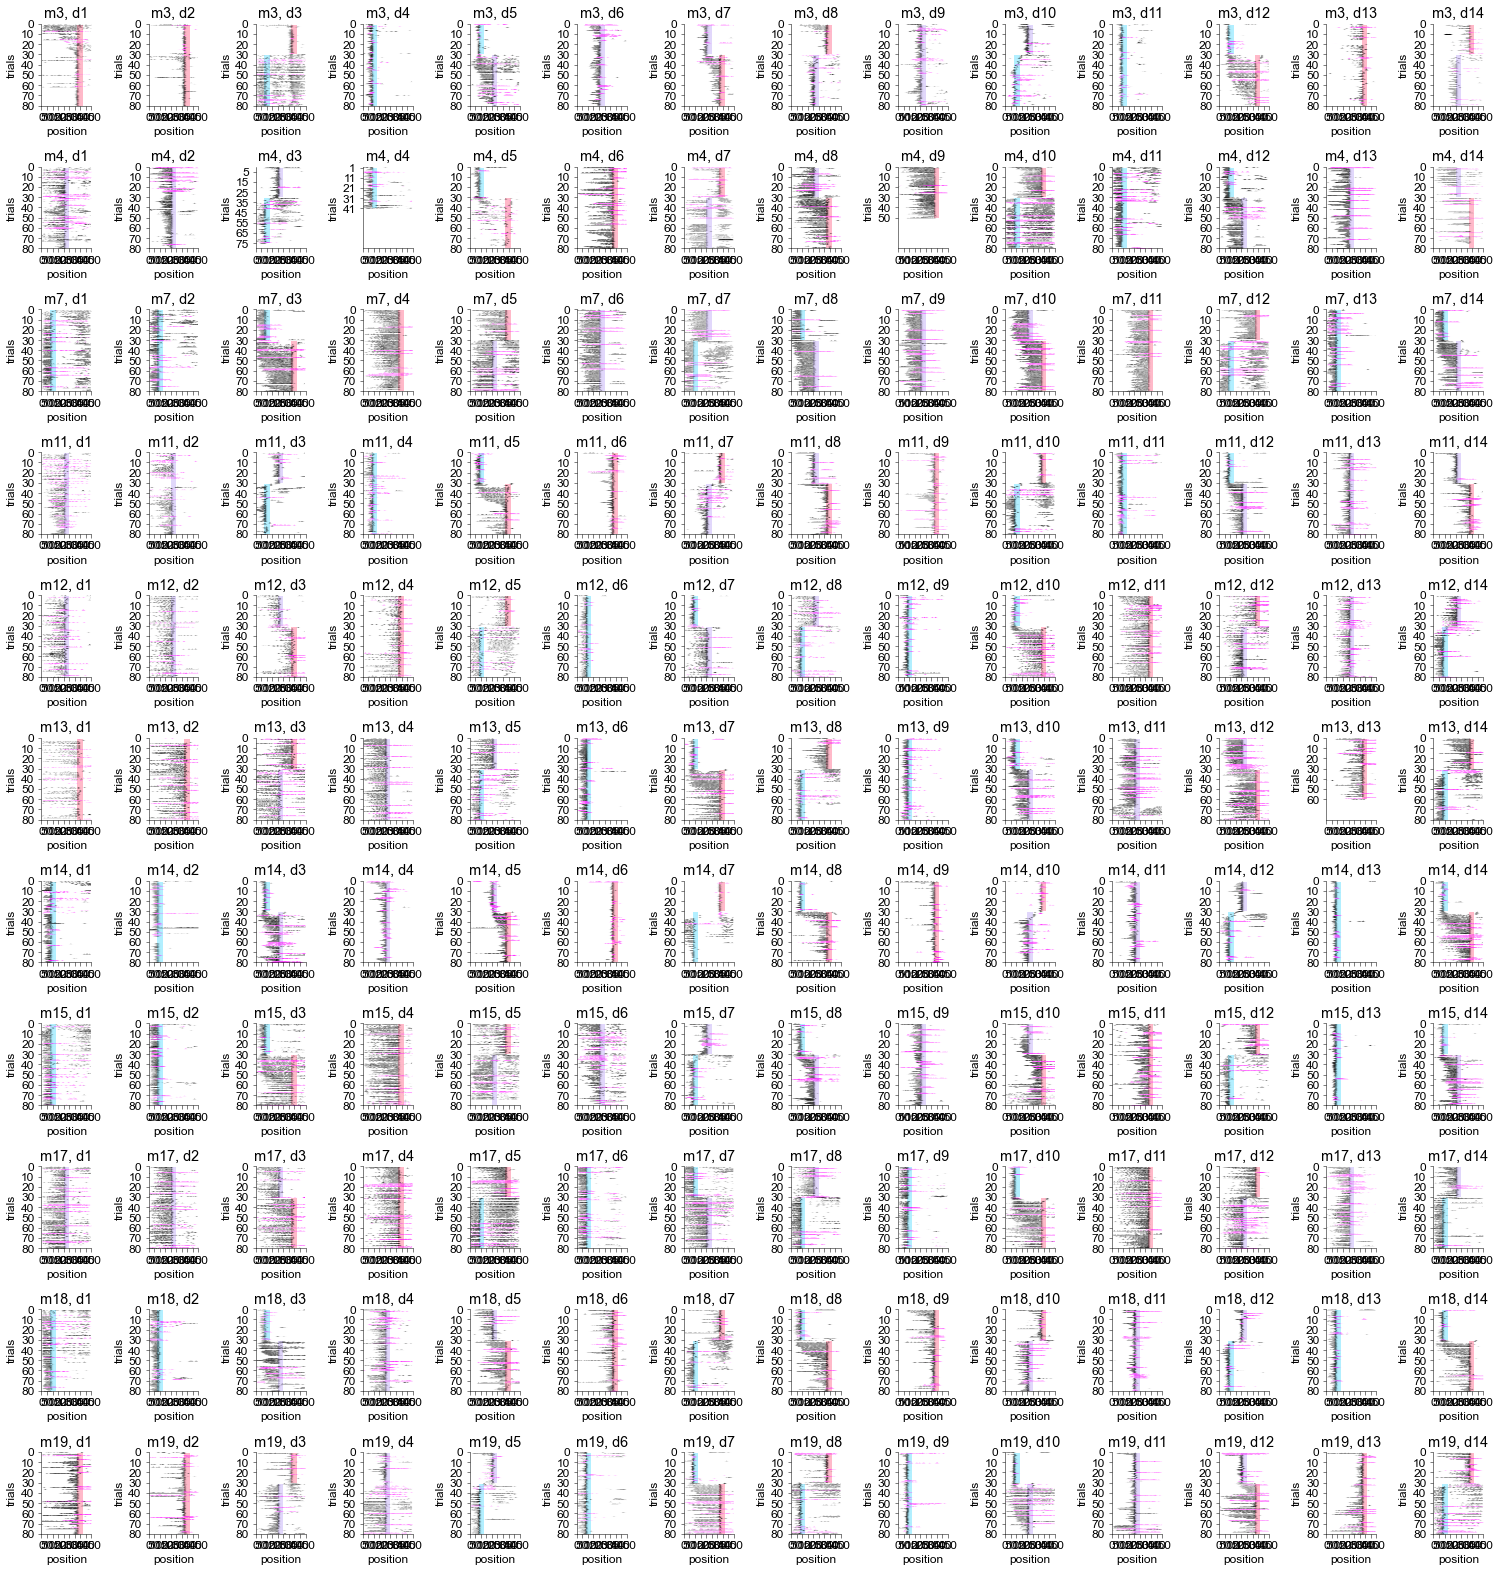

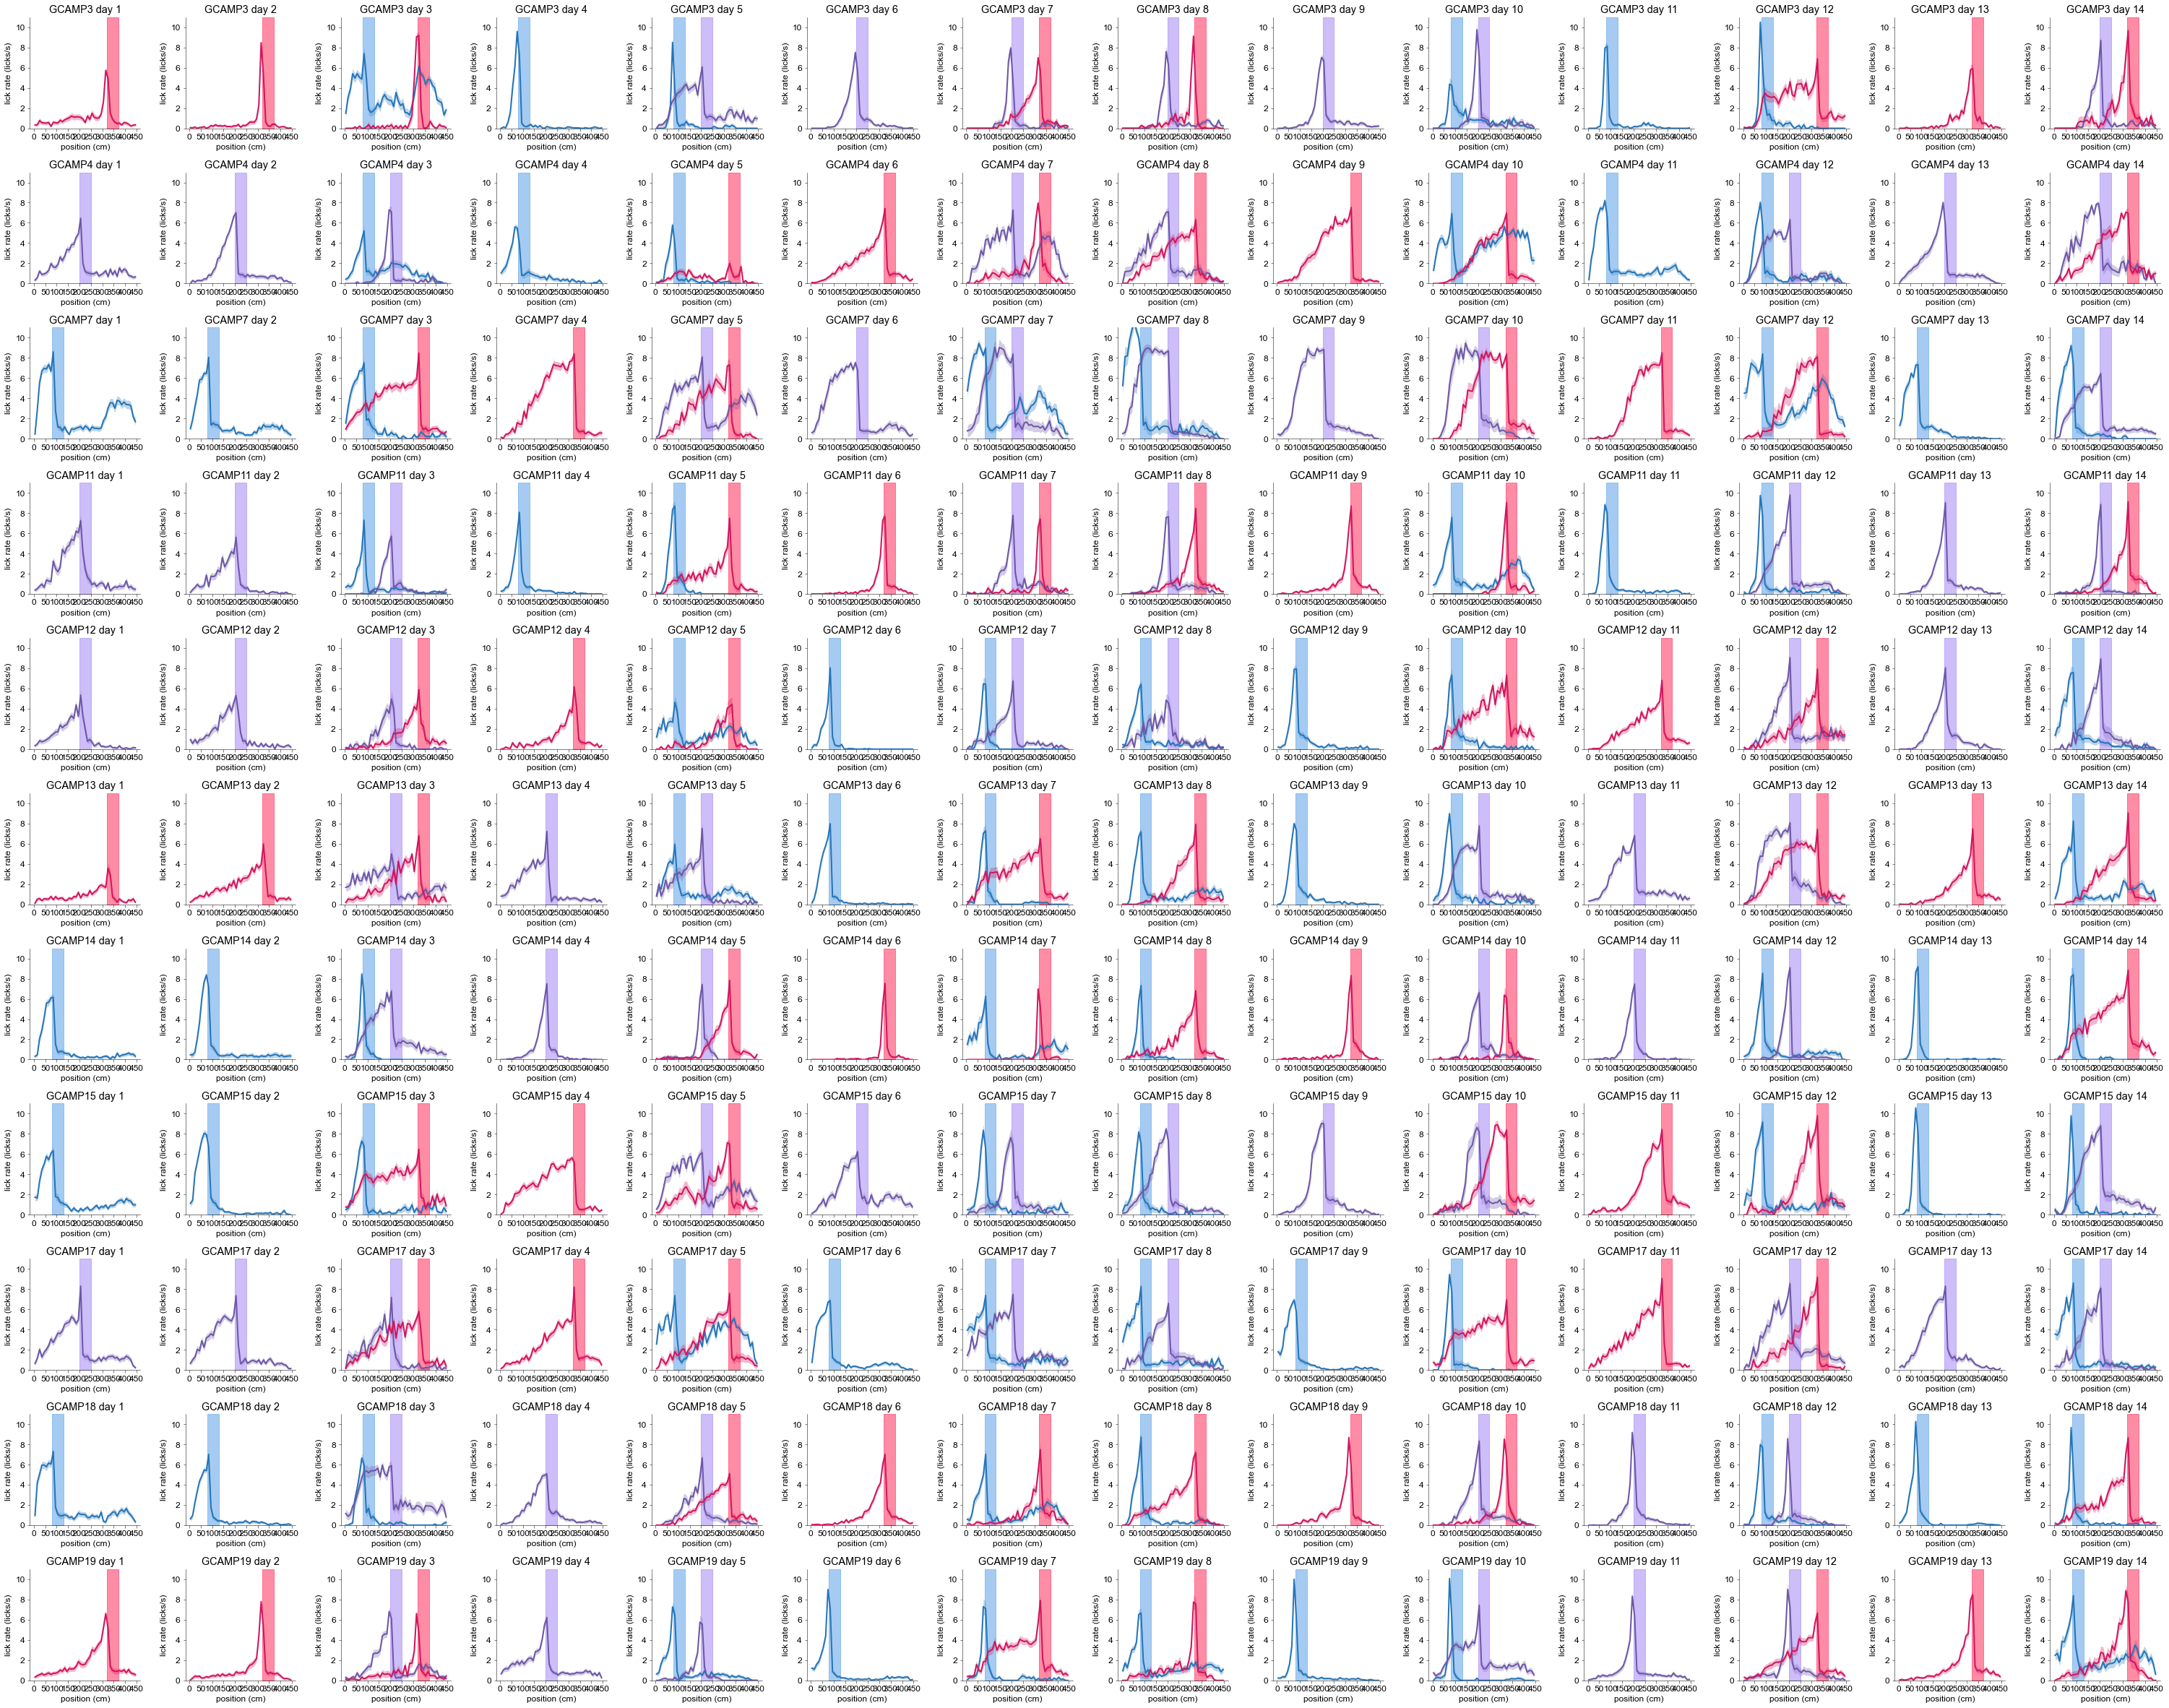

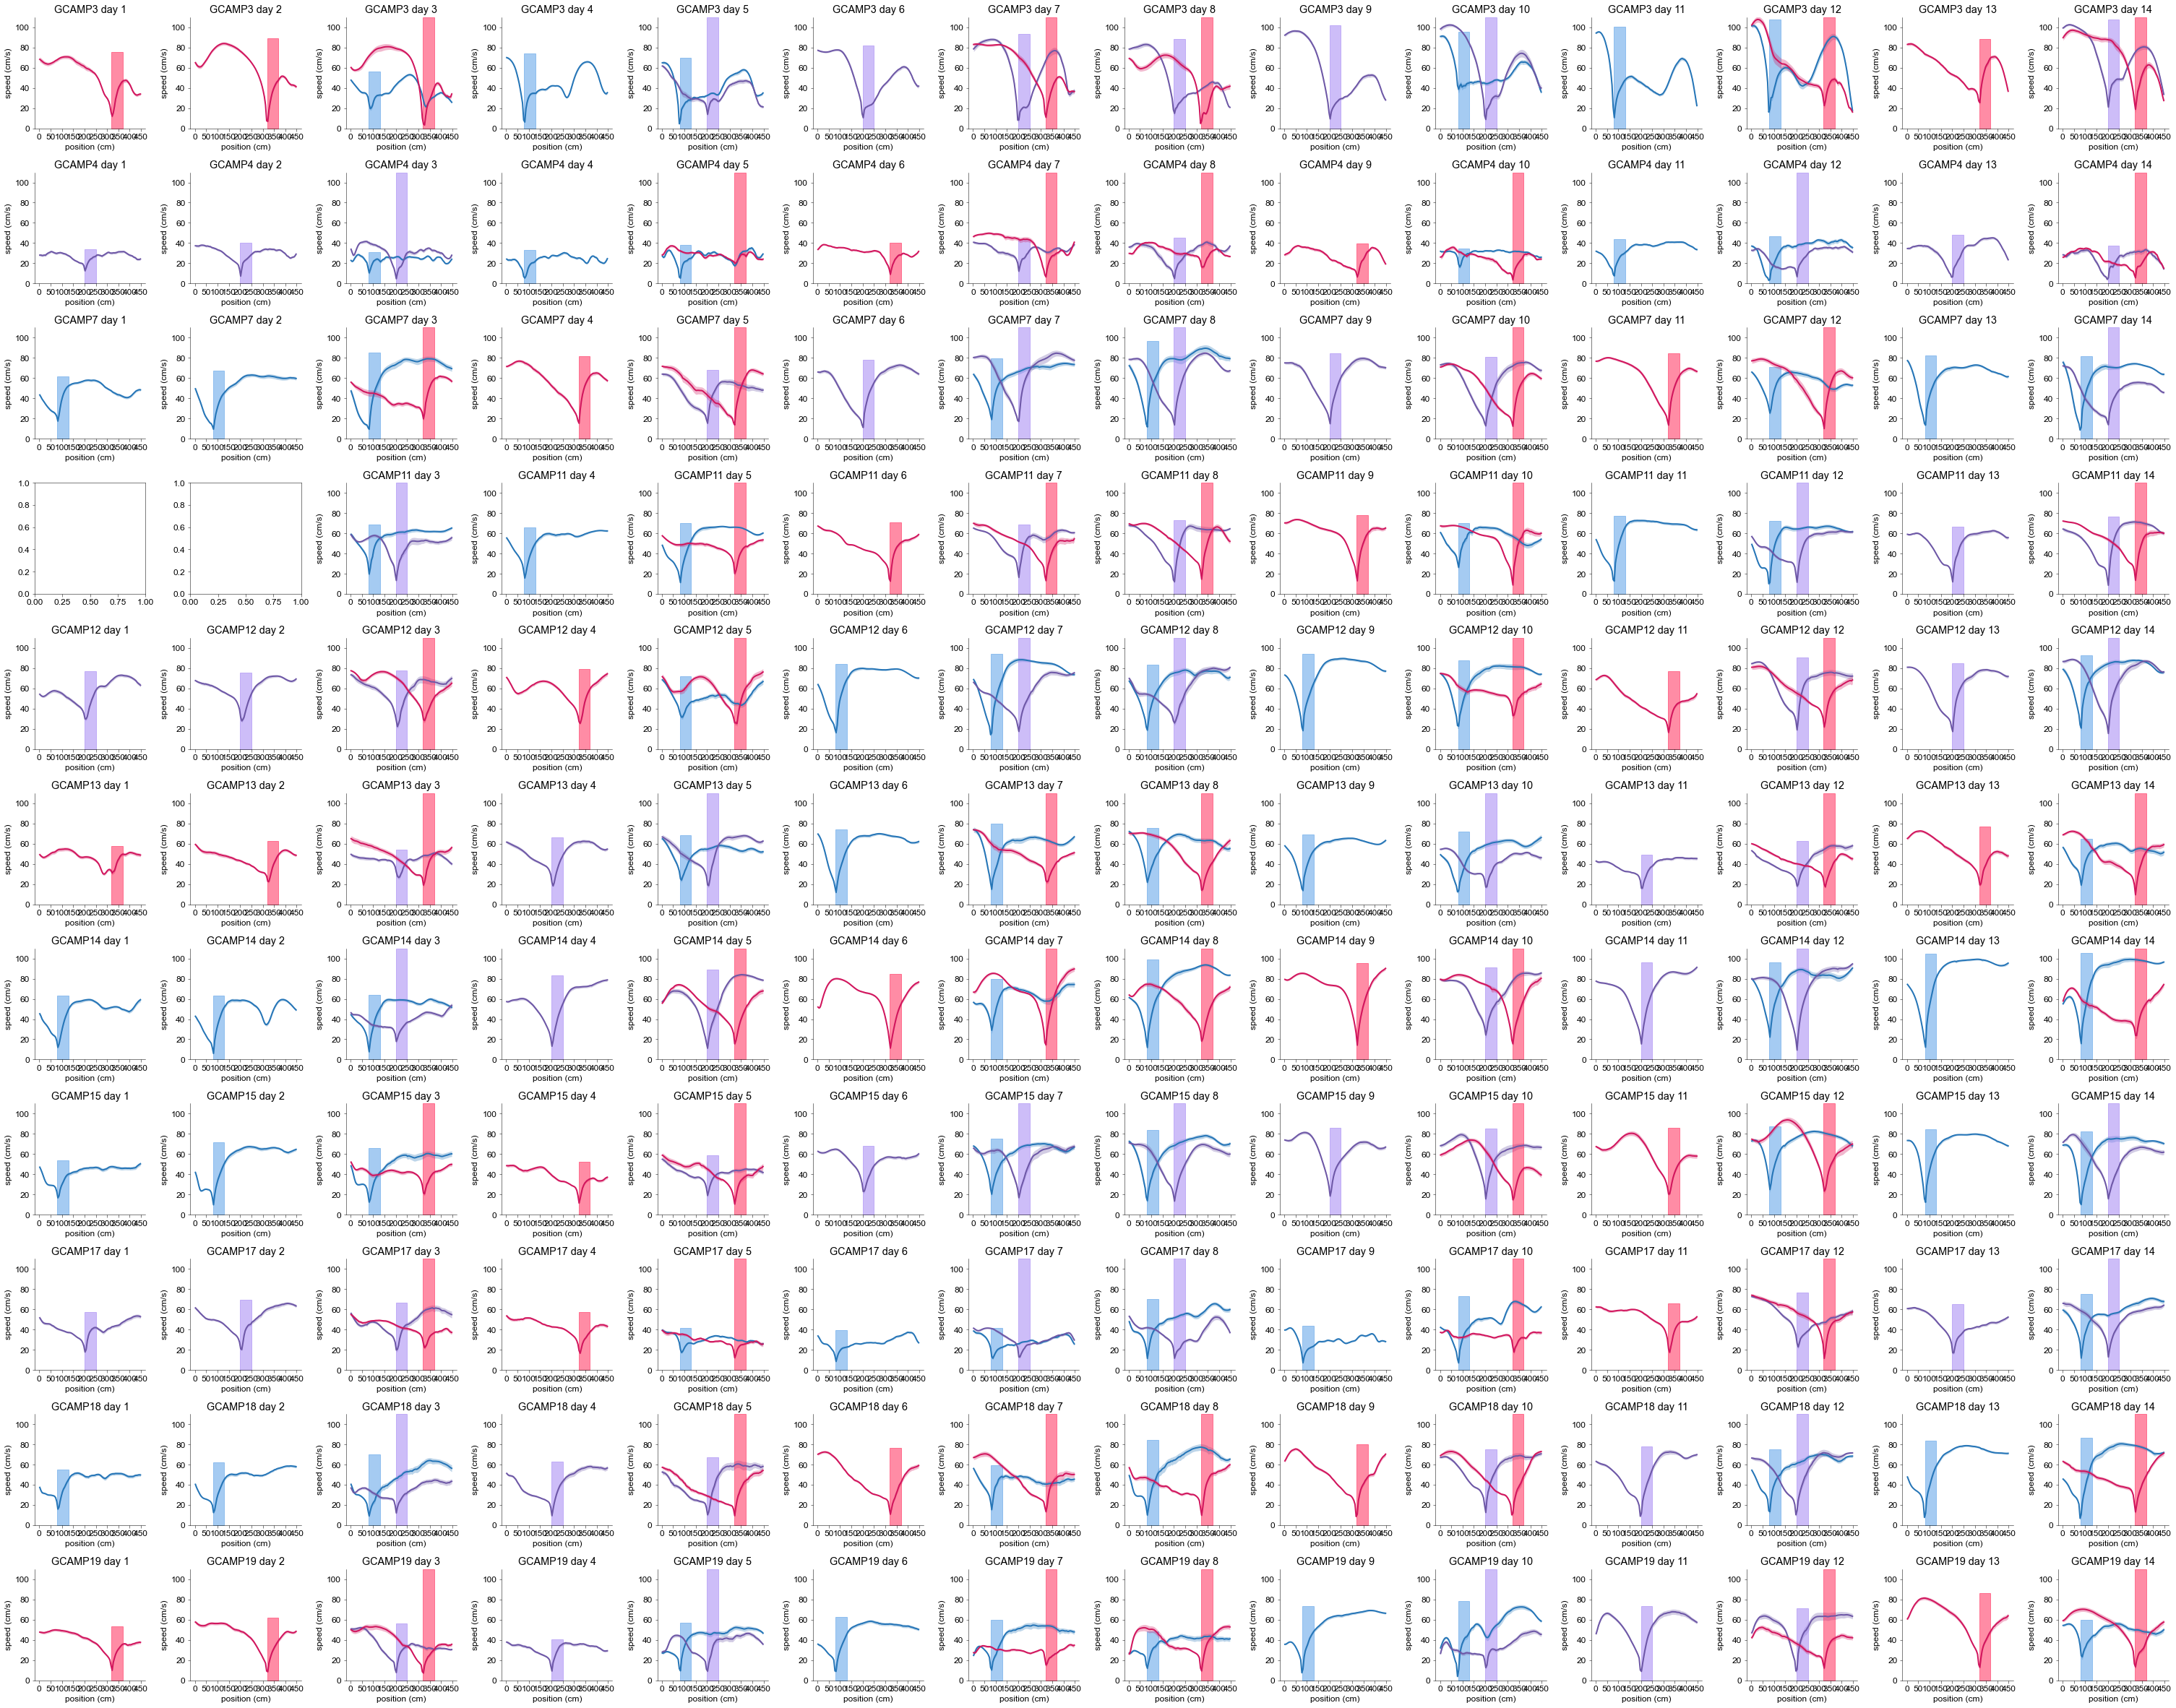

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) 
    
    if plot_rasters:
        fig_rast, ax_rast = plt.subplots(len(max_anim_list), len(exp_days), figsize=(1.5*len(exp_days),
                                                                                 2*len(max_anim_list),
                                                                               ))
    fig, ax = plt.subplots(len(max_anim_list),len(exp_days), figsize=(3*len(exp_days), 3*len(max_anim_list)))
    if plot_speed:
        fig_sp, ax_sp = plt.subplots(len(max_anim_list),len(exp_days), figsize=(3*len(exp_days), 3*len(max_anim_list)))

    for d_i, d in enumerate(exp_days):
        
        # Load existing multi_anim_sess, or create it if it does not exist
        multi_anim_sess, anim_list, anim_tag = get_multi_anim_sess_for_behavior(experiment,
                                                                                d,
                                                                                params,
                                                                               manual_anim_list = max_anim_list)
            
        trial_ant_ratio[d] = {} # anticipatory lick ratio
        trial_list[d] = {}
        p_trial_ant_ratio[d] = {}
        curr_zone_lickrate[d] = {}
        other_zone_lickrate[d] = {}
        curr_vs_other_ratio[d] = {} # ratio of licks in current reward zone to previous reward zone
        lickpos_std[d] = {}
        rzone_pos[d] = {}
        rzone_label[d] = {}
        
        for s in ['set 0','set 1']:
            trial_ant_ratio[d][s] = {}
            trial_list[d][s] = {}
            p_trial_ant_ratio[d][s] = {}
            curr_zone_lickrate[d][s] = {}
            other_zone_lickrate[d][s] = {}
            curr_vs_other_ratio[d][s] = {}

        for k in tt_keys:
            trial_ant_ratio[d][k] = {}
            trial_list[d][k] = {}
            p_trial_ant_ratio[d][k] = {}

        for an_i, an in enumerate(anim_list):
            
            sess_i = multi_anim_sess[an]['sess']
            if plot_speed:
                if 'speed' in sess_i.timeseries.keys():
                    speed_mat = TwoPUtils.spatial_analyses.trial_matrix(sess_i.timeseries['speed'][0], 
                                                       sess_i.vr_data['pos']._values, 
                                                       sess_i.trial_start_inds,
                                                       sess_i.teleport_inds,
                                                       bin_size=5, min_pos = 0,
                                                       max_pos=450, impute_nans=True)
                else:
                    speed_mat=[]
            
            # Plot smoothed lick rasters
            # Each row is an animal, each column is a day
            if plot and plot_rasters:
                isreward, morph = behav.get_trial_types(multi_anim_sess[an]['sess'])

                reward_zone, rz_label = behav.get_reward_zones(multi_anim_sess[an]['sess'])
                _, _, tcounts = behav.plot_norm_lick_raster(multi_anim_sess[an]['sess'],
                                            ax=ax_rast[max_anim_list.index(an),d_i],
                                            fig=fig_rast,
                                            isreward=isreward, morph=morph, 
                                            correct_sensor_error=True, hide_zeros=True, 
                                            rzone_labels=rz_label)
                ax_rast[max_anim_list.index(an),d_i].set_ylim(top=isreward.shape[0], 
                                                              bottom=0+(isreward.shape[0]-80))
                # collect trials that were dropped due to lick sensor error
                trial_counts.append(tcounts)
                
                ax_rast[max_anim_list.index(an),d_i].set_title("m%s, d%d" % (ut.get_mouse_number(an),
                                                                             d)
                                                              )

            
            lickpos_std[d][an] = behav.lick_pos_std(sess_i, correction_thr=correction_thr,
                                                   exclude_consum_licks=exclude_consum_licks)

            rzone_pos[d][an] = []
            rzone_label[d][an] = []

            trial_dict = behav.define_trial_subsets(multi_anim_sess[an]['sess'])

            trial_set0 = trial_dict['trial_set0']
            trial_set1 = trial_dict['trial_set1']
            two_sets_present = trial_dict['two_sets']


            pos = sess_i.trial_matrices['licks'][-1]  # bin centers

            # Iterate through reward zone locations
            for k in tt_keys:
                trials = np.where(multi_anim_sess[an]['rz label'] == [k])[0] 
                if len(trials) > 0:

                    lickdata = behav.calc_lick_metrics(sess_i,
                                                     trials,
                                                     correct_sensor_error=correct_sensor_error, 
                                                     correction_thr=correction_thr,
                                                     permute_licks=permute_licks,
                                                     exclude_reward_zone=exclude_reward_zone,
                                                        exclude_consum_licks=exclude_consum_licks,
                                                       zscore = zscore
                                                    )
                                                    
            
                    multi_anim_sess[an]['mean licks ' + k] = lickdata['mean_licks']
                    multi_anim_sess[an]['sem licks ' + k] = lickdata['sem_licks']
                    multi_anim_sess[an]['lick mat ' + k] = lickdata['lick_mat']
                    
                    # anticipatory lick ratio
                    trial_ant_ratio[d][k][an] = lickdata['trial_lick_ratio']
                    if trials[0] < 5:
                        trial_ant_ratio[d]['set 0'][an] = lickdata['trial_lick_ratio']
                    else:
                        trial_ant_ratio[d]['set 1'][an] = lickdata['trial_lick_ratio']

                    if permute_licks:
                        # shuffle the position for the lick PETH matrix
                        p_trial_ant_ratio[d][k][an] = lickdata['perm_trial_lick_ratio']#[trials,:,:]
                        if trials[0] < 5:
                            p_trial_ant_ratio[d]['set 0'][an] = lickdata['perm_trial_lick_ratio']#[trials,:,:]
                        else:
                            p_trial_ant_ratio[d]['set 1'][an] = lickdata['perm_trial_lick_ratio']#[trials,:,:]


                    if experiment =='NeuroMods':
                        ax[max_anim_list.index(an), d_i].set_ylim([0,9])
                    else:
                        ax[max_anim_list.index(an), d_i].set_ylim([0, 11])
                        
                    # Plot mean +/- sem licking
                    pt.plot_mean_sem(ax[max_anim_list.index(an), d_i],
                                     lickdata['mean_licks'], 
                                     lickdata['sem_licks'], 
                                     xvalues=pos,
                                     color=cmap[k][5])
                    rz = multi_anim_sess[an]['rzone'][np.where(multi_anim_sess[an]['rz label'] == [k])[0]]
                    ax[max_anim_list.index(an), d_i].fill_betweenx([0, ax[max_anim_list.index(an), d_i].get_ylim()[1]], 
                                                [rz[0, 0], rz[0, 0]], [rz[0, 1], rz[0, 1]],
                                     color=zone_clr[k],alpha =0.5)
                    ax[max_anim_list.index(an), d_i].spines['top'].set_visible(False)
                    ax[max_anim_list.index(an), d_i].spines['right'].set_visible(False)

                    ax[max_anim_list.index(an), d_i].set_xlabel('position (cm)')
                    ax[max_anim_list.index(an), d_i].set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
                    ax[max_anim_list.index(an), d_i].set_ylabel('lick rate (licks/s)')
                    ax[max_anim_list.index(an), d_i].set_title(f'{an} day {d}')

                    # Plot speed
                    if plot_speed:
                        if len(speed_mat)>0:
                            pt.plot_mean_sem(ax_sp[max_anim_list.index(an), d_i],
                                         np.nanmean(speed_mat[0][trials,:],axis=0), 
                                         ut.sem(speed_mat[0][trials,:],axis=0), 
                                         xvalues=speed_mat[-1],
                                         color=cmap[k][5])
                            ax_sp[max_anim_list.index(an), d_i].fill_betweenx([0, ax_sp[max_anim_list.index(an), d_i].get_ylim()[1]], 
                                                        [rz[0, 0], rz[0, 0]], [rz[0, 1], rz[0, 1]],
                                             color=zone_clr[k],alpha =0.5)
                            ax_sp[max_anim_list.index(an), d_i].spines['top'].set_visible(False)
                            ax_sp[max_anim_list.index(an), d_i].spines['right'].set_visible(False)

                            ax_sp[max_anim_list.index(an), d_i].set_xlabel('position (cm)')
                            ax_sp[max_anim_list.index(an), d_i].set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
                            ax_sp[max_anim_list.index(an), d_i].set_ylabel('speed (cm/s)')
                            ax_sp[max_anim_list.index(an), d_i].set_title(f'{an} day {d}')
                            ax_sp[max_anim_list.index(an), d_i].set_ylim([0, 110])
                                               
            else:
                multi_anim_sess[an]['mean licks ' + k] = None

            for tt in [0, 1]:
                other = np.abs(tt-1)
                curr_trials = trial_dict['trial_set' + str(tt)]
                other_trials = trial_dict['trial_set' + str(other)]
                trial_list[d]['set ' + str(tt)][an] = curr_trials
                
                # Get ratio of licking in current vs. previous/nonactive reward zone
                if len(curr_trials) > 0:
                    lickdata = behav.calc_lick_metrics(sess_i,
                                                       curr_trials,
                                                       correct_sensor_error=correct_sensor_error,
                                                       correction_thr=correction_thr,
                                                       permute_licks=permute_licks,
                                                       exclude_reward_zone=exclude_reward_zone,
                                                       exclude_consum_licks=exclude_consum_licks,
                                                       zscore=True
                                                       )
                    
                    curr_reward_zone = np.unique(
                        multi_anim_sess[an]['rzone'][curr_trials, 0])[0]
                    rzone_pos[d][an].append(curr_reward_zone)
                    rzone_label[d][an].append(
                        np.unique(multi_anim_sess[an]['rz label'][curr_trials])[0])

                    # for each trial
                    curr_zone_lickrate[d]['set ' + str(tt)][an] = np.nanmean(
                        lickdata['lick_mat'][:,np.logical_and(
                            pos >= (curr_reward_zone - 50), pos < curr_reward_zone)],axis=1)

                    # "other" zone not defined for the first day
                    other_reward_zone = None
                    if d not in [0,1,2]:
                        if len(other_trials) > 0:
                            other_reward_zone = np.unique(
                                multi_anim_sess[an]['rzone'][other_trials, :])
                        else:
                            # check whether we have a previous day to compare to
                            prev_day = exp_days[exp_days.index(d)-1]
                            data_exists = (prev_day in trial_list.keys()) and (an in rzone_pos[d].keys())
                            if data_exists:
                                prev_zone_is_different = len(np.where(np.squeeze(rzone_pos[prev_day][an]) != curr_reward_zone)[0]) > 0
                                if prev_zone_is_different:
                                    print("checking prev day...")
                                    other_reward_zone = rzone_pos[exp_days[d_i-1]][an][np.where(
                                        np.squeeze(rzone_pos[exp_days[d_i-1]][an]) != curr_reward_zone)[0][0]]
                                    
                                    other_reward_zone = [other_reward_zone, other_reward_zone+50]
                                else:
                                    continue
                        
                        if other_reward_zone is not None:
                            other_zone_lickrate[d]['set ' + str(tt)][an] = np.nanmean(
                                lickdata['lick_mat'][:,np.logical_and(
                                    pos >= (other_reward_zone[0] - 50),pos < other_reward_zone[end_ind])],axis=1)

                            curr_vs_other_ratio[d]['set ' + str(tt)][an] = (
                                (curr_zone_lickrate[d]['set ' + str(tt)][an] - other_zone_lickrate[d]['set ' + str(tt)][an]) /
                                (curr_zone_lickrate[d]['set ' + str(tt)][an] +
                                 other_zone_lickrate[d]['set ' + str(tt)][an])
                            )

    figfile = os.path.join(fig_dir, "anim%s_expday%s_LickPETH.pdf" % (anim_tag,
                                                                    "-".join([str(d) for d in exp_days]))) 
    fig_sp_file = os.path.join(fig_dir, "anim%s_expday%s_SpeedPETH.pdf" % (anim_tag,
                                                                    "-".join([str(d) for d in exp_days])))
    print(figfile)
    if save_figures and plot:
        fig.savefig(figfile)
        fig_sp.savefig(fig_sp_file)

    if plot_rasters:
        figfile_rast = os.path.join(fig_dir, "anim%s_expday%s_LickRasters_trunc.pdf" % (anim_tag,
                                                                                         "-".join([str(d) for d in exp_days])))
        if save_figures and plot:
            fig_rast.savefig(figfile_rast)

    

## Anticipatory Lick Ratio by trial block
10 trials per block

In [11]:
# By block
exp_days = [1,2,3,4,5,6,7,8,9,10,11,12,13,14] #[1,3,5,6,7,8,9,10,12,14,15,17]
experiment = 'MetaLearn'

daydata = dict()

# Whether to excluding reward zone from anticipatory lick ratio
exclude_reward_zone = True
exclude_consum_licks = False

#for currently rewarded zone
if exclude_reward_zone:
    end_ind = 0
else:
    end_ind = 1

#for previously rewarded zone
exclude_reward_zone_prev = False
if exclude_reward_zone_prev:
    end_ind_prev = 0
else:
    end_ind_prev = 1
    
tt_keys = ['A', 'B', 'C']


cmap = {}
zone_clr = {}
for k in tt_keys:
    if k == 'A':
        cmap[k] = cm.Blues(np.linspace(0.4, 1, 12))
        zone_clr[k] = (0, 0.8, 1, 0.3)
    elif k == 'B':
        cmap[k] = cm.Greys(np.linspace(0.4, 1, 12))
        zone_clr[k] = (0, 0.8, 1, 0.3)
    elif k == 'C':
        cmap[k] = cm.PuRd(np.linspace(0.4, 1, 12))
        zone_clr[k] = (1, 0.1, 0.3, 0.3)

for d_i, exp_day in enumerate(exp_days):
    
    daydata[exp_day] = {}
    
    if experiment == 'MetaLearn':
        if exp_day in [3,5,7,8,10,12,14]:
            def_block_by = 'reward_zone' # 'morph' or 'dream' or 'reward_zone' or None
        elif exp_day in [1,2,4,6,9,11,13]:
            def_block_by = None
            
    multi_anim_sess, anim_list, anim_tag = get_multi_anim_sess_for_behavior(experiment,exp_day,params, manual_anim_list=max_anim_list)

    # lick ratio by block for each trial set
    # trial set 0 = "before" the reward switch
    # trial set 1 = "after the reward switch
    lickratio_bb_0 = {} 
    lickratio_bb_1 = {}
    
    lickrate_bb_0 = {} 
    lickrate_bb_1 = {}
    
    currprev_ratio = {}
    
    rzone0 = {}
    rzone1 = {}
    rz_label0 = {}
    rz_label1 = {}

    blocks0 = {}
    blocks1 = {}
    
    ### ---- Start looping through animals ---- ###
    for an_i,an in tqdm(enumerate(anim_list)):
        
        if exclude_consum_licks:
            licks = behav.antic_consum_licks(multi_anim_sess[an]['sess'])
        else:
            licks = np.copy(multi_anim_sess[an]['sess'].vr_data['lick'].values)

        pos = multi_anim_sess[an]['sess'].trial_matrices['licks'][-1]  # bin centers
        bin_edges = multi_anim_sess[an]['sess'].trial_matrices['licks'][2]

        rawpos = multi_anim_sess[an]['sess'].vr_data['pos'].values
        tstarts = multi_anim_sess[an]['sess'].trial_start_inds
        tends = multi_anim_sess[an]['sess'].teleport_inds

        frame_time = behav.frametime(multi_anim_sess[an]['sess'])
        
        # Find 10-trial blocks and initialize output
        trial_dict = behav.define_trial_subsets(multi_anim_sess[an]['sess'],force_two_sets = False)
        if trial_dict['two_sets']==False:
            def_block_by_this_an=None
        else:
            def_block_by_this_an = copy.deepcopy(def_block_by)
            
        find_blocks0, find_blocks1 = behav.find_trial_blocks(multi_anim_sess[an],
                                                             exp_day,
                                                             define_blocks_by=def_block_by_this_an)

        rzone0[an] = np.unique(multi_anim_sess[an]['rzone'][find_blocks0[0]])[0]
        rzone1[an] = np.unique(multi_anim_sess[an]['rzone'][find_blocks1[0]])[0]
        
        rz_label0[an] = np.unique(multi_anim_sess[an]['rz label'][find_blocks0[0]])[0]
        rz_label1[an] = np.unique(multi_anim_sess[an]['rz label'][find_blocks1[0]])[0]
        
        blocks0[an] = find_blocks0
        blocks1[an] = find_blocks1

        lickratio_bb_0[an] = np.zeros((len(find_blocks0),2)) #*np.nan
        lickratio_bb_1[an] = np.zeros((len(find_blocks1),2)) #*np.nan
        
        lickrate_bb_0[an] = {'curr': np.zeros((len(find_blocks0),2))*np.nan,
                    'prev': np.zeros((len(find_blocks0),2))*np.nan
                    } 

        lickrate_bb_1[an] = {'curr': np.zeros((len(find_blocks1),2))*np.nan,
                    'prev': np.zeros((len(find_blocks1),2))*np.nan
                    }
        
        currprev_ratio[an] = np.zeros((len(find_blocks1),2))*np.nan
        
        # Blocks for trial set 0
        # `ti` is a list of trial indices in this block
        for ti, trials in enumerate(find_blocks0): 
            _, _, lickmat = behav.lickrate_PETH(licks,
                                             rawpos,
                                             bin_edges,
                                             tstarts,
                                             tends,
                                             frame_time=frame_time,
                                             trial_subset=trials,
                                               correct_sensor_error=True,
                                               correction_thr=0.3)
            
            # lick rate in anticipatory zone (50 cm prior to rzone to end set by exclude_reward_zone)
            ant_mat = lickmat[:, [np.logical_and(pos >= (np.unique(multi_anim_sess[an]['rzone'][trials, 0]) - 50),
                                                 pos < np.unique(multi_anim_sess[an]['rzone'][trials, end_ind]))][0]]

            # lick rate everywhere else (excluding reward zone)
            ant_mat_out = lickmat[:, [~np.logical_and(pos >= (np.unique(multi_anim_sess[an]['rzone'][trials, 0]) - 50),
                                                      pos < np.unique(multi_anim_sess[an]['rzone'][trials, 1]))][0]]

            # anticipatory lick ratio per trial
            all_trials_ratio = (
                               np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
                               np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
                               )
            
            # take the mean anticipatory lick ratio in each block of trials
            lickratio_bb_0[an][ti,:] = [ti, np.nanmean(all_trials_ratio)]
            
            lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
    
        # Blocks for trial set 1
        if len(find_blocks1)>1:
            prev_zone = rzone0[an] 
            for ti, trials in enumerate(find_blocks1):
                _, _, lickmat = behav.lickrate_PETH(licks,
                                             rawpos,
                                             bin_edges,
                                             tstarts,
                                             tends,
                                             frame_time=frame_time,
                                             trial_subset=trials,
                                                   correct_sensor_error=True,
                                               correction_thr=0.3)
                # lick rate in anticipatory zone (50 cm prior to rzone to end set by exclude_reward_zone)
                ant_mat = lickmat[:, [np.logical_and(pos >= (np.unique(multi_anim_sess[an]['rzone'][trials, 0]) - 50),
                                                     pos < np.unique(multi_anim_sess[an]['rzone'][trials, end_ind]))][0]]

                # lick rate everywhere else (excluding reward zone)
                ant_mat_out = lickmat[:, [~np.logical_and(pos >= (np.unique(multi_anim_sess[an]['rzone'][trials, 0]) - 50),
                                                          pos < np.unique(multi_anim_sess[an]['rzone'][trials, 1]))][0]]
                
                # for previous zone
                # lick rate in anticipatory zone (50 cm prior to rzone to end set by exclude_reward_zone)
                ant_mat_prev = lickmat[:, [np.logical_and(pos >= (np.unique(multi_anim_sess[an]['rzone'][find_blocks0[-1], 0]) - 50),
                                                     pos < np.unique(multi_anim_sess[an]['rzone'][find_blocks0[-1], end_ind_prev]))][0]]

                # lick rate everywhere else (excluding reward zone)
                ant_mat_out_prev = lickmat[:, [~np.logical_and(pos >= (np.unique(multi_anim_sess[an]['rzone'][find_blocks0[-1], 0]) - 50),
                                                          pos < np.unique(multi_anim_sess[an]['rzone'][find_blocks0[-1], 1]))][0]]

                all_trials_ratio = (
                                   np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
                                   np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
                                   )
                
                all_trials_ratio_prev = (
                                   np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
                                   np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
                                   )
                lickratio_bb_1[an][ti,:] = [ti, np.nanmean(all_trials_ratio)]
                
                lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
                lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, axis=1))]
                
                # ratio of lick rate in currently rewarded vs previously rewarded zone
                currprev_ratio[an][ti,:] = [ti, (
                    (lickrate_bb_1[an]['curr'][ti,1] - lickrate_bb_1[an]['prev'][ti,1]) /
                    (lickrate_bb_1[an]['curr'][ti,1] + lickrate_bb_1[an]['prev'][ti,1])
                )
                                           ]

    ## We're outside the animal loop now but still within the day loop
    daydata[exp_day].update(
    {'anim list': np.asarray(anim_list),
     'rzone 1': rzone0,
     'rzone 2': rzone1,
     'rz label 1':rz_label0,
     'rz label 2': rz_label1,
     'find blocks 1': blocks0,
     'find blocks 2': blocks1,
     'lickratio 1': lickratio_bb_0,
     'lickratio 2': lickratio_bb_1,
     'lickrate 1': lickrate_bb_0,
     'lickrate 2': lickrate_bb_1,
     'currprev ratio': currprev_ratio,
    })

    ## Find the mean for each block across animals 
              
    # loop through blocks
    max_blocks0 = max([len(lickratio_bb_0[an]) for an in anim_list])
    max_blocks1 = max([len(lickratio_bb_1[an]) for an in anim_list])
    # initialize block means
    block_acrossanim0 = {}
    block_acrossanim1 = {}
    block_means0 = {'lickratio': np.zeros((max_blocks0,2))*np.nan,
                   }
    block_means1 = {'lickratio': np.zeros((max_blocks1,2))*np.nan,
                   }

    for b in range(max_blocks0):
        # find which animals have this block
        has_block = np.where([np.isin(b,lickratio_bb_0[an][:,0]) for an in anim_list])[0]
        has_block = np.asarray(anim_list)[has_block]

        block_acrossanim0[b] = {}
        block_acrossanim0[b].update({'lickratio': [lickratio_bb_0[an][b,1] for an in has_block]})
        
        block_means0['lickratio'][b,0] = np.mean([lickratio_bb_0[an][b,1] for an in has_block])
        block_means0['lickratio'][b,1] = ut.sem([lickratio_bb_0[an][b,1] for an in has_block])

    for b in range(max_blocks1):
        # find which animals have this block
        has_block = np.where([np.isin(b,lickratio_bb_1[an][:,0]) for an in anim_list])[0]
        has_block = np.asarray(anim_list)[has_block]
        
        block_acrossanim1[b] = {}
        block_acrossanim1[b].update({'lickratio': [lickratio_bb_1[an][b,1] for an in has_block]})
        
        block_means1['lickratio'][b,0] = np.mean([lickratio_bb_1[an][b,1] for an in has_block])
        block_means1['lickratio'][b,1] = ut.sem([lickratio_bb_1[an][b,1] for an in has_block])

    daydata[exp_day].update(
        {'block means 1': block_means0,
         'block means 2': block_means1,
         'block across anim 1': block_acrossanim0,
         'block across anim 2': block_acrossanim1,
        }
    )
    

animal 0: GCAMP3
/data/2P/sess/GCAMP3/01_10_2022/Env1_LocationC_001_003.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/06_10_2022/Env1_LocationB_001_004.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/16_10_2022/Env1_LocationA_001_004.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/21_02_2023/Env1_LocationB_001_000.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/21_02_2023/Env1_LocationB_001_001.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/21_02_2023/Env1_LocationC_001_002.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/21_02_2023/Env1_LocationA_001_003.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/25_03_2024/Env1_LocationA_002_001.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/26_03_2024/Env2_LocationB_001_006.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/25_03_2024/Env2_LocationA_001_008.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/25_03_2024/Env1_LocationC_001_005.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
2it [00:00,  6.80it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
3it [00:00,  6.64it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  5.57it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  6.19it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_rat

animal 0: GCAMP3
/data/2P/sess/GCAMP3/02_10_2022/Env1_LocationC_003_001.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/07_10_2022/Env1_LocationB_002_002.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/17_10_2022/Env1_LocationA_002_003.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/22_02_2023/Env1_LocationB_003_000.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/22_02_2023/Env1_LocationB_002_005.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/22_02_2023/Env1_LocationC_002_002.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/22_02_2023/Env1_LocationA_002_002.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/26_03_2024/Env1_LocationA_002_003.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/27_03_2024/Env2_LocationB_002_009.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/26_03_2024/Env2_LocationA_002_008.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/26_03_2024/Env1_LocationC_002_005.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  7.26it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
3it [00:00,  7.32it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
/home/mari/local_repos/2p_repos/Sosa_et_al_2024/src/reward_relative/behavior.py:779: RuntimeWarning: invalid value encountered in true_divide
  licks_per_bin[trial, :] = licks_per_bin[trial, :] / \
4it [00:00,  5.91it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning

animal 0: GCAMP3
/data/2P/sess/GCAMP3/03_10_2022/Env1_LocationC_to_A_001_003.pickle
set 0: C trials / set 1: A trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/08_10_2022/Env1_LocationB_to_A_001_002.pickle
set 0: B trials / set 1: A trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/18_10_2022/Env1_LocationA_to_C_001_003.pickle
set 0: A trials / set 1: C trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/23_02_2023/Env1_LocationB_to_A_001_002.pickle
set 0: B trials / set 1: A trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/23_02_2023/Env1_LocationB_to_C_002_005.pickle
set 0: B trials / set 1: C trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/23_02_2023/Env1_LocationC_to_B_001_001.pickle
set 0: C trials / set 1: B trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/23_02_2023/Env1_LocationA_to_B_001_002.pickle
set 0: A trials / set 1: B trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/27_03_2024/Env1_LocationA_to_C_001_006.pickle
set 0: A trials / set 1: C trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/28_03_

1it [00:00,  7.17it/s]

set 0: C trials / set 1: A trials
set 0: B trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
3it [00:00,  6.78it/s]

set 0: A trials / set 1: C trials
set 0: B trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  7.08it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  7.39it/s]

set 0: B trials / set 1: C trials
set 0: C trials / set 1: B trials


7it [00:00,  7.64it/s]

set 0: A trials / set 1: B trials
set 0: A trials / set 1: C trials


8it [00:01,  7.70it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
9it [00:01,  7.72it/s]

set 0: B trials / set 1: C trials
set 0: A trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:195: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, axis=1))]
10it [00:01,  7.57it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true

set 0: C trials / set 1: B trials
animal 0: GCAMP3
/data/2P/sess/GCAMP3/04_10_2022/Env1_LocationA_002_002.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/09_10_2022/Env1_LocationA_002_002.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/19_10_2022/Env1_LocationC_002_004.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/24_02_2023/Env1_LocationA_002_002.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/24_02_2023/Env1_LocationC_002_006.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/24_02_2023/Env1_LocationB_002_004.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/24_02_2023/Env1_LocationB_003_008.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/28_03_2024/Env1_LocationC_002_006.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/29_03_2024/Env2_LocationC_002_008.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/28_03_2024/Env2_LocationB_002_004.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/28_03_2024/Env1_LocationB_002_001.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  7.31it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanm

animal 0: GCAMP3
/data/2P/sess/GCAMP3/05_10_2022/Env1_LocationA_to_B_001_004.pickle
set 0: A trials / set 1: B trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/10_10_2022/Env1_LocationA_to_C_001_002.pickle
set 0: A trials / set 1: C trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/20_10_2022/Env1_LocationC_to_B_001_002.pickle
set 0: C trials / set 1: B trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/25_02_2023/Env1_LocationA_to_C_001_008.pickle
set 0: A trials / set 1: C trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/25_02_2023/Env1_LocationC_to_A_001_005.pickle
set 0: C trials / set 1: A trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/25_02_2023/Env1_LocationB_to_A_002_005.pickle
set 0: B trials / set 1: A trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/25_02_2023/Env1_LocationB_to_C_001_008.pickle
set 0: B trials / set 1: C trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/29_03_2024/Env1_LocationC_to_B_002_005.pickle
set 0: C trials / set 1: B trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/30_03_

0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  6.83it/s]

set 0: A trials / set 1: B trials
set 0: A trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:188: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio_prev = (
3it [00:00,  7.01it/s]

set 0: C trials / set 1: B trials
set 0: A trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  7.23it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  7.45it/s]

set 0: C trials / set 1: A trials
set 0: B trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
6it [00:00,  7.62it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  7.75it/s]

set 0: B trials / set 1: C trials
set 0: C trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:195: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, axis=1))]
9it [00:01,  7.59it/s]

set 0: C trials / set 1: A trials
set 0: B trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
10it [00:01,  7.44it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
11it [00:01,  7.44it/s]


set 0: B trials / set 1: A trials
animal 0: GCAMP3
/data/2P/sess/GCAMP3/06_10_2022/Env1_LocationB_002_004.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/11_10_2022/Env1_LocationC_002_002.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/21_10_2022/Env1_LocationB_002_002.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/26_02_2023/Env1_LocationC_002_007.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/26_02_2023/Env1_LocationA_003_004.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/26_02_2023/Env1_LocationA_002_002.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/26_02_2023/Env1_LocationC_002_005.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/30_03_2024/Env1_LocationB_002_002.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/31_03_2024/Env2_LocationA_002_005.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/30_03_2024/Env2_LocationC_002_005.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/30_03_2024/Env1_LocationA_003_002.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  7.51it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
3it [00:00,  7.49it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-inp

animal 0: GCAMP3
/data/2P/sess/GCAMP3/07_10_2022/Env1_LocationB_to_C_001_001.pickle
set 0: B trials / set 1: C trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/12_10_2022/Env1_LocationC_to_B_001_002.pickle
set 0: C trials / set 1: B trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/22_10_2022/Env1_LocationB_to_A_001_002.pickle
set 0: B trials / set 1: A trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/27_02_2023/Env1_LocationC_to_B_001_002.pickle
set 0: C trials / set 1: B trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/27_02_2023/Env1_LocationA_to_B_001_002.pickle
set 0: A trials / set 1: B trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/27_02_2023/Env1_LocationA_to_C_004_006.pickle
set 0: A trials / set 1: C trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/27_02_2023/Env1_LocationC_to_A_001_009.pickle
set 0: C trials / set 1: A trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/31_03_2024/Env1_LocationB_to_A_001_002.pickle
set 0: B trials / set 1: A trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/01_04_

0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  7.18it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]


set 0: B trials / set 1: C trials
set 0: C trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:195: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, axis=1))]
3it [00:00,  6.91it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_

set 0: B trials / set 1: A trials
set 0: C trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  7.17it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  7.43it/s]

set 0: A trials / set 1: B trials
set 0: A trials / set 1: C trials


6it [00:00,  7.61it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  7.75it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: C trials / set 1: A trials
set 0: B trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
9it [00:01,  7.68it/s]

set 0: A trials / set 1: B trials
set 0: C trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
10it [00:01,  7.65it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:188: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio_prev = (
11it [00:01,  7.50it/s]

set 0: A trials / set 1: C trials
animal 0: GCAMP3
/data/2P/sess/GCAMP3/08_10_2022/Env1_C_to_Env2_B_001_002.pickle



/home/mari/local_repos/2p_repos/Sosa_et_al_2024/src/reward_relative/utilities.py:509: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanstd(x_, axis=axis, **kwargs) / np.sqrt(x_.shape[axis] - 1)


set 0: C trials / set 1: B trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/13_10_2022/Env1_B_to_Env2_C_001_002.pickle
set 0: B trials / set 1: C trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/23_10_2022/Env1_A_to_Env2_B_001_002.pickle
set 0: A trials / set 1: B trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/28_02_2023/Env1_B_to_Env2_C_001_002.pickle
set 0: B trials / set 1: C trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/28_02_2023/Env1_B_to_Env2_A_001_002.pickle
set 0: B trials / set 1: A trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/28_02_2023/Env1_C_to_Env2_A_001_002.pickle
set 0: C trials / set 1: A trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/28_02_2023/Env1_A_to_Env2_C_002_007.pickle
set 0: A trials / set 1: C trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/01_04_2024/Env1_A_to_Env2_B_002_006.pickle
set 0: A trials / set 1: B trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/02_04_2024/Env2_B_to_Env1_A_001_007.pickle
set 0: B trials / set 1: A trials
animal 9: GCAMP18
/data/2P/sess/GC

0it [00:00, ?it/s]

set 0: A trials / set 1: C trials
animal 10: GCAMP19
/data/2P/sess/GCAMP19/01_04_2024/Env1_C_to_Env2_A_001_002.pickle
set 0: C trials / set 1: A trials


1it [00:00,  7.16it/s]

set 0: C trials / set 1: B trials
set 0: B trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:188: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio_prev = (
2it [00:00,  7.05it/s]<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipytho

set 0: A trials / set 1: B trials
set 0: B trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  7.46it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: B trials / set 1: A trials
set 0: C trials / set 1: A trials


6it [00:00,  7.61it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  7.76it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: A trials / set 1: C trials
set 0: A trials / set 1: B trials


9it [00:01,  7.76it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: B trials / set 1: A trials
set 0: A trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
10it [00:01,  7.68it/s]<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
11it [00:01,  7.50it/s]
/home/mari/local_repos/2p_repos/Sosa_et_al_2024/src/reward_relative/utilities.py:509: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanstd(x_, axis=axis, **kwargs) / np.sqrt(x_.shape[axis] - 1)


set 0: C trials / set 1: A trials
animal 0: GCAMP3
/data/2P/sess/GCAMP3/09_10_2022/Env2_LocationB_002_002.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/14_10_2022/Env2_LocationC_004_002.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/24_10_2022/Env2_LocationB_002_003.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/01_03_2023/Env2_LocationC_002_008.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/01_03_2023/Env2_LocationA_002_005.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/01_03_2023/Env2_LocationA_003_005.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/01_03_2023/Env2_LocationC_002_008.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/02_04_2024/Env2_LocationB_002_003.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/03_04_2024/Env1_LocationA_002_011.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/02_04_2024/Env1_LocationC_002_003.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/02_04_2024/Env2_LocationA_002_002.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
3it [00:00,  7.83it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
4it [00:00,  7.93it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
6it [00:00,  8.19it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  8.

animal 0: GCAMP3
/data/2P/sess/GCAMP3/10_10_2022/Env2_LocationB_to_A_001_001.pickle
set 0: B trials / set 1: A trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/15_10_2022/Env2_LocationC_to_A_001_002.pickle
set 0: C trials / set 1: A trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/25_10_2022/Env2_LocationB_to_C_001_002.pickle
set 0: B trials / set 1: C trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/02_03_2023/Env2_LocationC_to_A_002_011.pickle
set 0: C trials / set 1: A trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/02_03_2023/Env2_LocationA_to_C_001_005.pickle
set 0: A trials / set 1: C trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/02_03_2023/Env2_LocationA_to_B_001_002.pickle
set 0: A trials / set 1: B trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/02_03_2023/Env2_LocationC_to_B_002_008.pickle
set 0: C trials / set 1: B trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/03_04_2024/Env2_LocationB_to_C_002_008.pickle
set 0: B trials / set 1: C trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/05_04_

0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  6.77it/s]

set 0: B trials / set 1: A trials
set 0: C trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:195: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, axis=1))]
3it [00:00,  7.07it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_

set 0: B trials / set 1: C trials
set 0: C trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  7.30it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarni

set 0: A trials / set 1: C trials
set 0: A trials / set 1: B trials


6it [00:00,  7.59it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  7.80it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: C trials / set 1: B trials
set 0: B trials / set 1: C trials


9it [00:01,  7.76it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: A trials / set 1: C trials
set 0: C trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
10it [00:01,  7.76it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
11it [00:01,  7.57it/s]
/home/mari/local_repos/2p_repos/Sosa_et_al_2024/src/reward_relative/utilities.py:509: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanstd(x_, axis=axis, **kwargs) / np.sqrt(x_.shape[axis] - 1)


set 0: A trials / set 1: B trials
animal 0: GCAMP3
/data/2P/sess/GCAMP3/11_10_2022/Env2_LocationA_002_002.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/16_10_2022/Env2_LocationA_002_003.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/26_10_2022/Env2_LocationC_002_002.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/03_03_2023/Env2_LocationA_002_005.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/03_03_2023/Env2_LocationC_002_011.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/03_03_2023/Env2_LocationB_002_002.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/03_03_2023/Env2_LocationB_002_005.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/04_04_2024/Env2_LocationC_002_004.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/06_04_2024/Env1_LocationC_002_008.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/04_04_2024/Env1_LocationB_002_005.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/04_04_2024/Env2_LocationB_002_002.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
3it [00:00,  7.63it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  7.84it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
6it [00:00,  7.81it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
9it [00:01,  8.07it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
10it [00:01,  8.01it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
11it [00:01,  7.87it/s]


animal 0: GCAMP3
/data/2P/sess/GCAMP3/12_10_2022/Env2_LocationA_to_C_001_002.pickle
set 0: A trials / set 1: C trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/17_10_2022/Env2_LocationA_to_B_001_003.pickle
set 0: A trials / set 1: B trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/27_10_2022/Env2_LocationC_to_A_002_001.pickle
set 0: C trials / set 1: A trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/04_03_2023/Env2_LocationA_to_B_001_003.pickle
set 0: A trials / set 1: B trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/04_03_2023/Env2_LocationC_to_B_002_008.pickle
set 0: C trials / set 1: B trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/04_03_2023/Env2_LocationB_to_C_001_002.pickle
set 0: B trials / set 1: C trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/04_03_2023/Env2_LocationB_to_A_001_007.pickle
set 0: B trials / set 1: A trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/05_04_2024/Env2_LocationC_to_A_001_002.pickle
set 0: C trials / set 1: A trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/07_04_

0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
/home/mari/local_repos/2p_repos/Sosa_et_al_2024/src/reward_relative/behavior.py:779: RuntimeWarning: invalid value encountered in true_divide
  licks_per_bin[trial, :] = licks_per_bin[trial, :] / \
1it [00:00,  7.57it/s]

set 0: A trials / set 1: C trials
set 0: A trials / set 1: B trials


3it [00:00,  7.01it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: C trials / set 1: A trials
set 0: A trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:195: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, axis=1))]
5it [00:00,  7.48it/s]

set 0: C trials / set 1: B trials
set 0: B trials / set 1: C trials


6it [00:00,  7.60it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  7.81it/s]

set 0: B trials / set 1: A trials
set 0: C trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
9it [00:01,  7.98it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (


set 0: C trials / set 1: B trials
set 0: B trials / set 1: A trials


<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
10it [00:01,  7.90it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:188: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio_prev = (
11it [00:01,  7.61it/s]
/home/mari/local_repos/2p_repos/Sosa_et_al_2024/src/reward_relative/utilities.py:509: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanstd(x_, axis=axis, **kwargs) / np.sqrt(x_.shape[axis] - 1)


set 0: B trials / set 1: C trials
animal 0: GCAMP3
/data/2P/sess/GCAMP3/13_10_2022/Env2_LocationC_002_003.pickle
animal 1: GCAMP4
/data/2P/sess/GCAMP4/18_10_2022/Env2_LocationB_002_002.pickle
animal 2: GCAMP7
/data/2P/sess/GCAMP7/28_10_2022/Env2_LocationA_002_003.pickle
animal 3: GCAMP11
/data/2P/sess/GCAMP11/05_03_2023/Env2_LocationB_002_007.pickle
animal 4: GCAMP12
/data/2P/sess/GCAMP12/05_03_2023/Env2_LocationB_003_004.pickle
animal 5: GCAMP13
/data/2P/sess/GCAMP13/05_03_2023/Env2_LocationC_004_005.pickle
animal 6: GCAMP14
/data/2P/sess/GCAMP14/05_03_2023/Env2_LocationA_002_008.pickle
animal 7: GCAMP15
/data/2P/sess/GCAMP15/06_04_2024/Env2_LocationA_002_005.pickle
animal 8: GCAMP17
/data/2P/sess/GCAMP17/08_04_2024/Env1_LocationB_002_007.pickle
animal 9: GCAMP18
/data/2P/sess/GCAMP18/06_04_2024/Env1_LocationA_002_005.pickle
animal 10: GCAMP19
/data/2P/sess/GCAMP19/06_04_2024/Env2_LocationC_002_002.pickle


0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  8.07it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
3it [00:00,  7.78it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  7.81it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  7.

animal 0: GCAMP3
/data/2P/sess/GCAMP3/14_10_2022/Env2_LocationC_to_B_001_002.pickle
set 0: C trials / set 1: B trials
animal 1: GCAMP4
/data/2P/sess/GCAMP4/19_10_2022/Env2_LocationB_to_C_001_002.pickle
set 0: B trials / set 1: C trials
animal 2: GCAMP7
/data/2P/sess/GCAMP7/29_10_2022/Env2_LocationA_to_B_002_004.pickle
set 0: A trials / set 1: B trials
animal 3: GCAMP11
/data/2P/sess/GCAMP11/06_03_2023/Env2_LocationB_to_C_001_006.pickle
set 0: B trials / set 1: C trials
animal 4: GCAMP12
/data/2P/sess/GCAMP12/06_03_2023/Env2_LocationB_to_A_001_003.pickle
set 0: B trials / set 1: A trials
animal 5: GCAMP13
/data/2P/sess/GCAMP13/06_03_2023/Env2_LocationC_to_A_001_002.pickle
set 0: C trials / set 1: A trials
animal 6: GCAMP14
/data/2P/sess/GCAMP14/06_03_2023/Env2_LocationA_to_C_001_005.pickle
set 0: A trials / set 1: C trials
animal 7: GCAMP15
/data/2P/sess/GCAMP15/07_04_2024/Env2_LocationA_to_B_001_003.pickle
set 0: A trials / set 1: B trials
animal 8: GCAMP17
/data/2P/sess/GCAMP17/09_04_

0it [00:00, ?it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
1it [00:00,  6.38it/s]

set 0: C trials / set 1: B trials
set 0: B trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_pre

set 0: A trials / set 1: B trials
set 0: B trials / set 1: C trials


<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
4it [00:00,  6.56it/s]<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
5it [00:00,  6.99it/s]

set 0: B trials / set 1: A trials
set 0: C trials / set 1: A trials


6it [00:00,  7.25it/s]<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
7it [00:00,  7.52it/s]<ipython-input-11-4a843de4e27f>:144: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:145: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:143: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:151: RuntimeWarning: Mean of empty slice
  lickrate_bb_0[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]


set 0: A trials / set 1: C trials
set 0: A trials / set 1: B trials


<ipython-input-11-4a843de4e27f>:184: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) - np.nanmean(ant_mat_out, axis=1)) / (
<ipython-input-11-4a843de4e27f>:185: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat, axis=1) + np.nanmean(ant_mat_out, axis=1)
<ipython-input-11-4a843de4e27f>:183: RuntimeWarning: invalid value encountered in true_divide
  all_trials_ratio = (
<ipython-input-11-4a843de4e27f>:189: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) - np.nanmean(ant_mat_out_prev, axis=1)) / (
<ipython-input-11-4a843de4e27f>:190: RuntimeWarning: Mean of empty slice
  np.nanmean(ant_mat_prev, axis=1) + np.nanmean(ant_mat_out_prev, axis=1)
<ipython-input-11-4a843de4e27f>:194: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['curr'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat, axis=1))]
<ipython-input-11-4a843de4e27f>:195: RuntimeWarning: Mean of empty slice
  lickrate_bb_1[an]['prev'][ti,:] = [ti,np.nanmean(np.nanmean(ant_mat_prev, ax

set 0: B trials / set 1: A trials
set 0: A trials / set 1: C trials


11it [00:01,  7.29it/s]

set 0: C trials / set 1: A trials


### Plot anticipatory lick ratio by block, across animals

Individual lines are colored by the reward zone active for each mouse on each trial set  \
Grey lines are pre-switch mean ± sem, black lines are post-switch mean ± sem

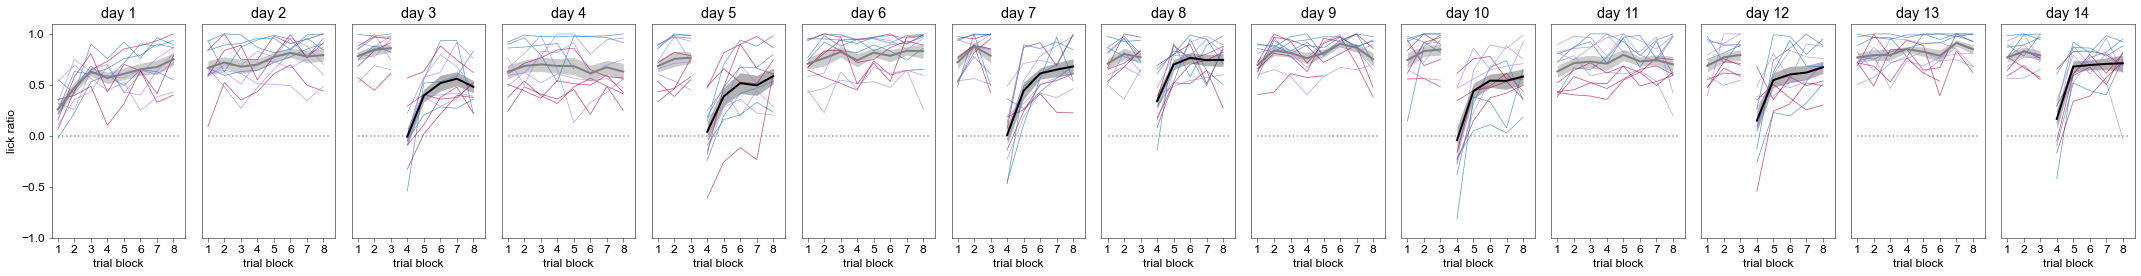

In [12]:
meankey = 'lickratio'

plot_as_dots = False
plot_as_lines = True

chance = 0

if exclude_reward_zone:
    tag = '_rzoneexcl'
else:
    tag = '_rzoneincl_excConsumLicks'

fig, ax = plt.subplots(1, len(exp_days), figsize=(30, 4))

for di, day in enumerate(exp_days):

    anim_list = daydata[day]['anim list']
    ### plot only blocks that have >1 animal ###
    b_list0 = np.concatenate([daydata[day]['lickratio 1'][an][:, 0]
                              for an in anim_list]).astype(int)
    b_list1 = np.concatenate([daydata[day]['lickratio 2'][an][:, 0]
                              for an in anim_list]).astype(int)
    plot_b0 = np.where(np.bincount(b_list0) > 2)[0]
    plot_b1 = np.where(np.bincount(b_list1) > 2)[0]

    for an_i, an in enumerate(anim_list):
        # Get reward zone colors
        clr1, clr2 = pt.color_def(experiment, day, rz_label0=daydata[day]['rz label 1'][an],
                                  rz_label1=daydata[day]['rz label 2'][an],)
        if day in [1, 2, 4, 6, 9, 11, 13]:
            x0 = 0
        elif day in [3, 5, 7, 8, 10, 12, 14]:
            x0 = 0
            x1 = 3

        if meankey == 'lickratio':
            if plot_as_dots:
                jitter0 = np.random.uniform(low=-0.1, high=0.1, size=(1,))
                try:
                    ax[di].scatter(daydata[day]['lickratio 1'][an][plot_b0, 0]+jitter0+x0,
                                   daydata[day][key[0]][an][plot_b0, 1], s=5, color=clr1, alpha=0.7)
                except:
                    #np.linspace(-0.1,0.1,len(daydata[day]['lickratio 1'][an][:,0]))
                    ax[di].scatter(daydata[day]['lickratio 1'][an][:, 0]+jitter0+x0,
                                   daydata[day][key[0]][an][:, 1], s=5, color=clr1, alpha=0.7)
            elif plot_as_lines:
                try:
                    ax[di].plot(daydata[day]['lickratio 1'][an][plot_b0, 0]+x0, daydata[day]['lickratio 1'][an][plot_b0, 1],
                                color=clr1, alpha=0.7, linewidth=0.75)
                except:
                    ax[di].plot(daydata[day]['lickratio 1'][an][:, 0]+x0, daydata[day]['lickratio 1'][an][:, 1],
                                color=clr1, alpha=0.7, linewidth=0.75)

        if np.any(daydata[day]['block means 2'][meankey]):
            jitter1 = np.random.uniform(low=-0.1, high=0.1, size=(1,))
            if meankey == 'lickratio':
                if plot_as_dots:
                    try:
                        #np.linspace(-0.1,0.1,len(len(daydata[day]['lickratio 2'])))
                        ax[di].scatter(daydata[day]['lickratio 2'][an][plot_b1, 0]+jitter1+x1,
                                       daydata[day][key[1]][an][plot_b1, 1], s=5, color=clr2, alpha=0.7)
                    except:
                        ax[di].scatter(daydata[day]['lickratio 2'][an][:, 0]+jitter1+x1,
                                       daydata[day][key[1]][an][:, 1], s=5, color=clr2, alpha=0.7)
                elif plot_as_lines:
                    try:
                        ax[di].plot(daydata[day]['lickratio 2'][an][plot_b1, 0]+x1, daydata[day]['lickratio 2'][an][plot_b1, 1],
                                    color=clr2, alpha=0.7, linewidth=0.75)
                    except:
                        ax[di].plot(daydata[day]['lickratio 2'][an][:, 0]+x1, daydata[day]['lickratio 2'][an][:, 1],
                                    color=clr2, alpha=0.7, linewidth=0.75)

    max_blocks0 = len(plot_b0)
    max_blocks1 = len(plot_b1)

    block_means0 = daydata[day]['block means 1']
    block_means1 = daydata[day]['block means 2']

    if len(daydata[day]['block means 1'][meankey]) > 1:
        pt.plot_mean_sem(ax[di], daydata[day]['block means 1'][meankey][plot_b0, 0],
                         daydata[day]['block means 1'][meankey][plot_b0, 1],
                         xvalues=plot_b0 + x0,
                         color='grey',
                         sem_alpha=0.4)

    if np.any(daydata[day]['block means 2'][meankey]):
        pt.plot_mean_sem(ax[di], daydata[day]['block means 2'][meankey][plot_b1, 0],
                         daydata[day]['block means 2'][meankey][plot_b1, 1],
                         xvalues=plot_b1 + x1,
                         color='black',
                         sem_alpha=0.3)

    ax[di].set_xlabel('trial block')
    ax[di].set_ylim([0, 0.6])  # [0,0.6] for reward
    ax[di].set_xticks(np.arange(0, math.ceil(ax[di].get_xlim()[1]), 1))
    ax[di].set_xticklabels([str(n) for n in np.arange(
        1, math.ceil(ax[di].get_xlim()[1]+1), 1)])
    ax[di].set_title(f"day {day}")

if meankey == 'lickratio':
    ax[0].set_ylabel('lick ratio')
    [ax[i].set_ylim([-1, 1.1]) for i in range(len(exp_days))]
    [ax[i].hlines(0, 0, ax[i].get_xlim()[1], color=(
        0.6, 0.6, 0.6, 1), linestyle=":") for i in range(len(exp_days))]

[ax[i+1].set_yticks([]) for i, d in enumerate(exp_days[1:])]
plt.grid(False, which='major', axis='x')

save_figures = False
if save_figures:
    fig.savefig(os.path.join(fig_dir, "anim%s_expday%d-%d_meanAntLickRatio_byblock%s_lines.pdf" % (
        anim_tag, exp_days[0], exp_days[-1], tag)), bbox_inches='tight')